# Part I : Quel(le) data scientist êtes-vous ?
## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset Aquila, vous réaliserez :
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    


## Répondez aux questions 

Bonne chance!

In [75]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt
plt.style.use('ggplot')


from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix

### 1) Importer le tableau de données dans un dataframe 

In [76]:
# Importer les données dans un dataframe
df = pd.read_csv('/content/data/data.csv',sep=",",decimal=",")

# Afficher un échantillon aléatoire d'éléments 
df.sample(5)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
296,Burns & McDonnell,Data scientist,R/machine learning/Excel/VBA,Phd,0.0,Paris
9123,TRC,Data scientist,C/C++/Java/Python,Master,3.5,Paris
9505,Northwestern University,Data architecte,Python/Spark/Hive/Hadoop,No diploma,2.5,Lyon
3490,Brigham & Women's Hospital(BWH),Data scientist,Excel/VBA/R,Master,2.0,Toulouse
1342,Nuveen,Data scientist,Excel/VBA/R/Python/PySpark,Master,3.5,Marseille


### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

###   2.1 Récupérer le nombre d'observations dans ce dataset

In [77]:
print("Le nombre total d'obsercations dans ce dataset : {}".format(df.shape[0]))

Le nombre total d'obsercations dans ce dataset : 9582


### 2.2 Verifier s'il y a des valeurs manquantes

In [78]:
df.isna().any()

Entreprise       True
Metier           True
Technologies    False
Diplome         False
Experience       True
Ville           False
dtype: bool

### 2.3 Compter le nombre des valeurs manquantes par variable 

In [79]:
print("le nombre des valeurs manquantes par variable est :")
df.isna().sum()

le nombre des valeurs manquantes par variable est :


Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64

### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

#### 3.1 Compter le nombre des valeurs manquantes pour la variable "Experience"

In [80]:
print("Le nombre de valeurs manquantes avant l'imputation pour les data scientists :{}".format(df.loc[df.Metier=='Data scientist','Experience'].isna().sum()))
print("Le nombre de valeurs manquantes avant l'imputation pour les ddata engineers :{}".format(df.loc[df.Metier=='Data engineer','Experience'].isna().sum()))

Le nombre de valeurs manquantes avant l'imputation pour les data scientists :32
Le nombre de valeurs manquantes avant l'imputation pour les ddata engineers :20


#### 3.2 Réaliser l'imputation des valeurs manquantes

In [81]:
df.loc[df.Metier=='Data scientist','Experience']=df.loc[df.Metier=='Data scientist','Experience'].fillna(df[df['Metier'] == 'Data scientist']['Experience'].dropna().median())
df.loc[df.Metier=='Data engineer','Experience']=df.loc[df.Metier=='Data engineer','Experience'].fillna(df[df['Metier'] == 'Data engineer']['Experience'].dropna().mean())

#### 3.3 Vérification

In [82]:
print("Le nombre de valeurs manquantes après l'imputation pour les data scientists :{}".format(df.loc[df.Metier=='Data scientist','Experience'].isna().sum()))
print("Le nombre de valeurs manquantes après l'imputation pour les ddata engineers :{}".format(df.loc[df.Metier=='Data engineer','Experience'].isna().sum()))

Le nombre de valeurs manquantes après l'imputation pour les data scientists :0
Le nombre de valeurs manquantes après l'imputation pour les ddata engineers :0


### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

In [83]:
moy_ds=df.loc[df.Metier=='Data scientist','Experience'].dropna().mean()
moy_lds=df.loc[df.Metier=='Lead data scientist','Experience'].dropna().mean()
moy_de=df.loc[df.Metier=='Data engineer','Experience'].dropna().mean()
print("Les années moyennes pour chaque profil : \n")
print("Lead data scientist :",round(moy_lds,3))
print("Data enginner       :",round(moy_de,3))
print("Data scientist      :",round(moy_ds,3))


Les années moyennes pour chaque profil : 

Lead data scientist : 3.965
Data enginner       : 2.985
Data scientist      : 2.241


### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

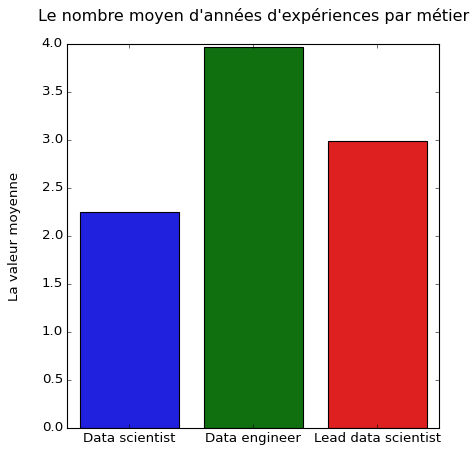

In [84]:
plt.figure(figsize=(6, 6))
plt.style.use('classic')
sb.barplot(x=df['Metier'].value_counts().keys().drop('Data architecte'),y=[moy_ds,moy_lds,moy_de])
plt.ylabel("La valeur moyenne\n")
plt.title("Le nombre moyen d'années d'expériences par métier\n")
plt.show()

### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation.  

#### Les valeurs manquantes restantes de la variable Experience doivent être remplies en premier lieu.

In [85]:
 moy_da=df.loc[df.Metier=='Data architecte','Experience'].dropna().mean()
df.loc[df.Metier=='Lead data scientist','Experience']=df.loc[df.Metier=='Lead data scientist','Experience'].fillna(moy_lds)
df.loc[df.Metier=='Data architecte','Experience']=df.loc[df.Metier=='Data architecte','Experience'].fillna(moy_da)

#### Transformation de la variable continue "Expérience" en une nouvelle variable catégorielle "Exp_label". 



In [86]:
labels=['Debutant','Confirme','Avance','Expert']
df['Exp_label']=pd.cut(df['Experience'],bins=[-1,2,6,10,30], labels=labels)
df.tail(10)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label
9572,State Street,Data scientist,Excel/VBA/R/Python/PySpark,Master,2.0,Lyon,Debutant
9573,Jacobs,Data scientist,Matlab/C/C++/Python/Scikit-learn,Phd,2.5,Bordeaux,Confirme
9574,Georgia Tech Research Institute,Data architecte,MongoDB/SQL/Docker,Master,3.5,Toulouse,Confirme
9575,Hatch,Data engineer,Python/Pyspark/Spark,No diploma,4.0,Toulouse,Confirme
9576,Ra Pharmaceutical,Data scientist,R/machine learning/Excel/VBA,Phd,2.5,Toulouse,Confirme
9577,Massachusetts General Hospital(MGH),Data scientist,C++/R/Python/Matlab/Matplotlib,Master,1.5,Lyon,Debutant
9578,Charles River Analytics,Data scientist,Excel/Python/Matlab/R/machine learning/anglais,Master,11.0,Toulouse,Expert
9579,Ball Aerospace,Data scientist,R/machine learning/Excel/VBA,Master,1.0,Paris,Debutant
9580,Takeda Pharmaceutical,Data scientist,Python/Pyspark/machine learning/Microsoft Azure,Master,17.0,Rennes,Expert
9581,Vertex,Data scientist,VBA/Python/Excel/R,Phd,0.0,Paris,Debutant


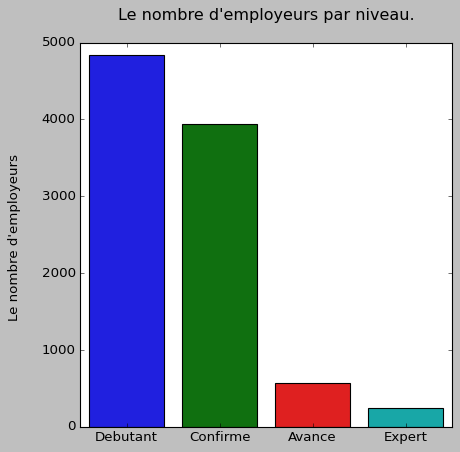

In [87]:
plt.figure(figsize=(6, 6))
sb.barplot(x=df['Exp_label'].value_counts().keys(),y=df['Exp_label'].value_counts().values)
plt.ylabel("Le nombre d'employeurs \n")
plt.title("Le nombre d'employeurs par niveau.\n")
plt.show()

### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique

In [88]:
most_used_tech=df['Technologies'].value_counts()[:5]
print("les 5 technologies les plus utilisées sont :\n")
print(most_used_tech)

les 5 technologies les plus utilisées sont :

SQL/R/Python//Big data                                539
SAS/Teradata/SQL/R/Python/Machine learning/Anglais    458
C++/R/Python/Matlab/Matplotlib                        273
SPSS/Excel/SAS/R/machine learning/AI/Scoring          250
Hadoop/Hive/Vertica/Tableau                           250
Name: Technologies, dtype: int64


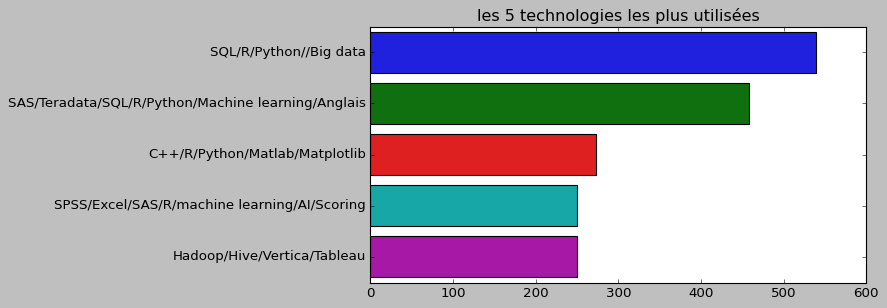

In [89]:
plt.figure(figsize=(8, 4))
sb.barplot(x=most_used_tech.values,y=most_used_tech.keys())
plt.title("les 5 technologies les plus utilisées")
plt.show()

### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

#**Analyse du forme**

### On crée une copie du Dataset

In [90]:
data=df.copy()

data.shape

(9582, 7)

### Etudier tous les éléments de chaque caractéristique



In [91]:
for column in data:
  unique_val=data[column].unique()
  nr_unique_val=len(unique_val)
  if nr_unique_val<10:
    print("the number of value for feature {} : {} ---- {}".format(column,nr_unique_val,unique_val))
  else:
    print("the number of value for feature {} : {}".format(column,nr_unique_val))

the number of value for feature Entreprise : 1383
the number of value for feature Metier : 5 ---- ['Data scientist' 'Data architecte' 'Lead data scientist' 'Data engineer'
 nan]
the number of value for feature Technologies : 57
the number of value for feature Diplome : 4 ---- ['Master' 'Phd' 'Bachelor' 'No diploma']
the number of value for feature Experience : 24
the number of value for feature Ville : 14
the number of value for feature Exp_label : 4 ---- ['Debutant', 'Confirme', 'Avance', 'Expert']
Categories (4, object): ['Debutant' < 'Confirme' < 'Avance' < 'Expert']


### On prepare un pipeline qui fait l'encodage et la normalisation des données

In [92]:
# 1) Pipeline pour les variables numériques
numerical_pipeline=make_pipeline(SimpleImputer(),StandardScaler())

# 2) Pipeline pour les autres variables qui sont qualitatives
categorical_pipeline=make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder())


In [93]:
numerical_features=['Experience']
categorical_features=['Technologies','Diplome','Exp_label']

In [94]:
# Construire un ColumnTransformer à partir des transformateurs donnés
preprocessor= make_column_transformer((numerical_pipeline,numerical_features),(categorical_pipeline,categorical_features))

In [95]:
data=data[['Experience','Technologies','Diplome','Exp_label']]
x_encoded=preprocessor.fit_transform(data)

### Initialisation de l'algorithme Kmeans et de notre modèle de clustering

In [96]:
kmeans =KMeans(n_clusters=2)
model= make_pipeline(preprocessor,kmeans)

In [97]:
# Entrainer le model
kmeans.fit(x_encoded)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## Les caracteristiques les plus imortantes des deux clusteres

### Il faut coder le Dataset avec une autre facon  pour pouvoir extraire les caracteristiques les plus imortantes qui ont l'impact de distinguer les clusters


In [98]:
data1=data.copy()
data1=data1[['Experience','Technologies','Diplome','Exp_label']]
le = preprocessing.LabelEncoder()
df_le = data1.loc[:,['Experience']]
data1=data1.drop(['Experience'],axis=1)
for culumn in data1:
  df_le[culumn]=le.fit_transform(data1[culumn])
df_le.head()

,Experience,Technologies,Diplome,Exp_label
0,1.0,27,1,2
1,3.0,34,1,1
2,3.0,51,1,1
3,1.5,2,1,2
4,2.0,26,3,2


### Rajouter la variable "Labels" au data-frame initial et Configuration des points dans le plan

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


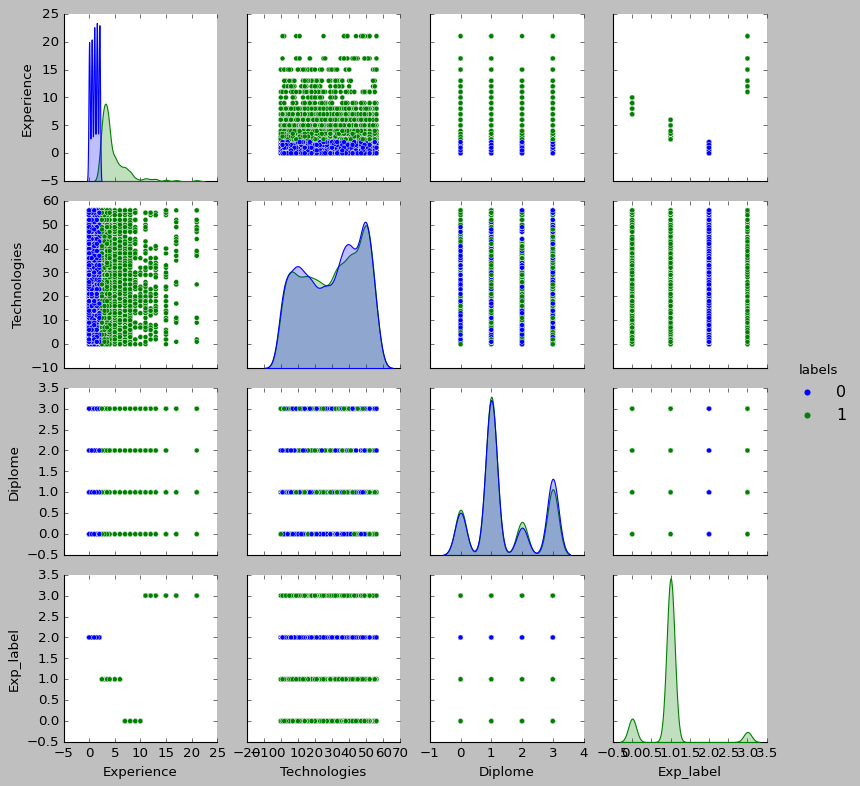

In [99]:
labels = kmeans.labels_
B=df_le.copy()
B['labels']=labels

#des variables prises par paires
#On colore les points selon les labels
sb.pairplot(B,hue='labels')

### A partir ce graphique, et sur la diagonale principal, les fonctions de densité conditionnelle  permet de savoir quand les variables sont prises de maniere individuelle lesquels ont le plus d'impact sur la séparabilité des clusters <br>On peut constater donc que les caractistiques les plus imortantes à distinguer les deux clusteres sont : **Experience et Exp_label**

### Il est également possible de calculer les moyennes des caractéristiques par Label pour savoir comment elles diffèrent les deux clusters.<br> Cette technique peut être utile lorsque nous avons plusieurs variables

In [100]:
 #on crée tout d'abord deux sous-DataFrames pour cluster_1 et cluster_2
gb=B.groupby(labels)
#effectifs par classe 
print(gb.size())
#Moyennes par classe
gb.mean()

0    4842
1    4740
dtype: int64


,Experience,Technologies,Diplome,Exp_label,labels
0,1.033561,29.914085,1.457043,2.0000,0
1,4.633871,29.953165,1.394937,0.9827,1


### Le rapport de correlation peut aussi aider à identifier les correlation entre les Labels et les caracteristiques (forte ou faible)<br> Le tableau montre qu'il y a une correlation forte entre la variable **Experience** et **Labels**, aussi il une correlation forte entre la variable **Exp_label** et **Labels**

In [101]:
B.corr()

,Experience,Technologies,Diplome,Exp_label,labels
Experience,1.000000,-0.004550,-0.020287,-0.359571,0.665770
Technologies,-0.004550,1.000000,0.046966,-0.020321,0.001153
Diplome,-0.020287,0.046966,1.000000,0.014435,-0.030952
Exp_label,-0.359571,-0.020321,0.014435,1.000000,-0.786682
labels,0.665770,0.001153,-0.030952,-0.786682,1.000000


## **Evaluation**

### La métrique utilisée est inertia

In [102]:
print(kmeans.inertia_)

22259.26708131416


# Ce code à pour objectif d'identifier le nombre ideale des clusters 

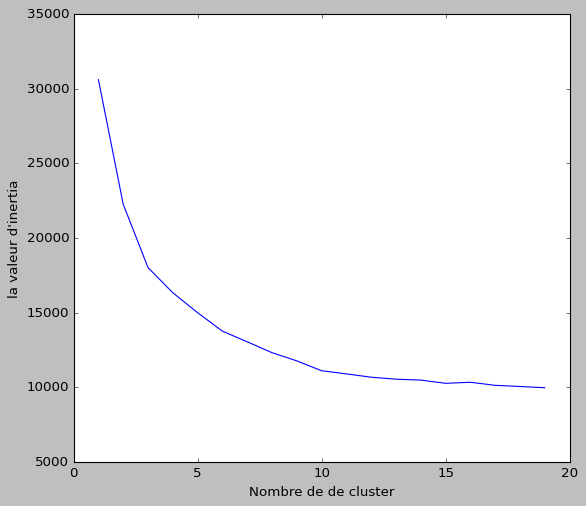

In [103]:
inertie=[]
k_range= range(1,20)
for clustr in k_range:
  x_encoded=preprocessor.fit_transform(data)
  kmeans = KMeans(n_clusters=clustr, max_iter = 100, algorithm = 'auto')
  kmeans.fit(x_encoded)
  inertie.append(kmeans.inertia_)

plt.figure(figsize=(8,7))
plt.plot(k_range,inertie)
plt.xlabel("Nombre de de cluster")
plt.ylabel("la valeur d'inertia")
plt.show()




### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

## On affiche d'abord les métiers manquants dans la base de données

In [104]:
print("Le nombre des métiers manquants dans la base de données est : ",len(df[df['Metier'].isna()]))
df[df['Metier'].isna()]

Le nombre des métiers manquants dans la base de données est :  19


,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label
346,Jacobs,NaN,Python/Spark/GNU/Linux,No diploma,2.5,Paris,Confirme
2058,Ball Aerospace,NaN,VBA/Python/Excel/R,Master,15.0,Lyon,Expert
2670,"eHire, LLC",NaN,Java/C/C++/R/Python,Master,1.5,Toulouse,Debutant
2899,Norfolk Southern Corp,NaN,Python/Tensorflow/scikit-learn/Deep learning/R,Phd,0.0,Grenoble,Debutant
3346,J.E. Ranta Associates,NaN,Cassandra/MongoDB/NoSQL/AWS,Master,7.0,Rennes,Avance
4248,KPMG,NaN,Python/Microsoft Azure/R/SQL,Phd,2.0,Lyon,Debutant
4290,"Pandora Media, Inc.",NaN,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Phd,1.5,Toulouse,Debutant
4292,Partners HealthCare(PHS),NaN,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Master,8.0,Bordeaux,Avance
5425,Ashton Lane Group,NaN,Python/Pyspark/Spark,No diploma,5.0,Lyon,Confirme
5593,Lighthouse Lab Services,NaN,Python/R/machine learning/Excel/VBA/C++,Master,3.0,Lyon,Confirme


### On prépare les données d'entrainement et les données des métiers manquants

In [105]:
mum_category=preprocessing.LabelEncoder()
metier_manq= df.loc[:,'Metier'].isna()
x=np.array(df_le[~metier_manq])
y=mum_category.fit_transform(df.loc[~metier_manq,'Metier'].dropna())
#Metiers à predire
metier_a_predire=np.array(df_le[metier_manq])

In [106]:
x.shape, y.shape, metier_a_predire.shape

((9563, 4), (9563,), (19, 4))

In [107]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.25, shuffle=True , random_state=0)

### Nous allons tester différents modèles d'apprentissage automatique afin de choisir le modèle ayant la plus grande précision pour la prédiction des métiers manquants.<br>Et pour chaque alogorithme, nous allons utiliser une technique pour sélectionner les meilleurs paramètres. 

### 1. Model KNeighborsClassifier


In [108]:
param_grid={'n_neighbors':np.arange(1,20),
            'metric':['euclidean','manhattan']}
grid=GridSearchCV(KNeighborsClassifier(),param_grid)
grid.fit(X_train,y_train)
model_KNN=grid.best_estimator_
print(grid.best_score_,grid.best_params_)

0.8568036582936062 {'metric': 'manhattan', 'n_neighbors': 6}


###2. Model DecisionTreeClassifier


In [109]:
param_grid={'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
grid=GridSearchCV(DecisionTreeClassifier(),param_grid)
grid.fit(X_train,y_train)
model_DT=grid.best_estimator_
print(grid.best_score_,grid.best_params_)
 

0.880367870385219 {'criterion': 'entropy', 'max_depth': 15}


##3. Model RandomForestClassifier 



In [110]:
param_grid = {
    'n_estimators'      : [320,330,340],
    'max_depth'         : [8, 9, 10, 11, 12],
    'random_state'      : [0],
    #'max_features': ['auto'],
    #'criterion' :['gini']
}

model_rfc = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, n_jobs=-1)
model_rfc.fit(X_train,y_train)
print(model_rfc.best_score_,model_rfc.best_params_)
model_rfc=model_rfc.best_estimator_

0.8530395916131515 {'max_depth': 12, 'n_estimators': 320, 'random_state': 0}


Pour essayer d'améliorer les performances de notre modèle, nous pouvons tester une méthode qui consiste à former plusieurs modèles d'apprentissage automatique et à considérer ensuite toutes leurs prédictions 

In [111]:
model=VotingClassifier([('rf', model_rfc),
                          ('Tree',model_DT),
                          ('KNN',model_KNN)],
                         voting='soft')

for model in(model_rfc,model_DT,model_KNN,model):
  model.fit(X_train,y_train)
  print(model.__class__.__name__,model.score(X_test,y_test))

RandomForestClassifier 0.8607277289836889
DecisionTreeClassifier 0.8841488916771225
KNeighborsClassifier 0.8665830196570473
VotingClassifier 0.8841488916771225


Cette technique de vote ne fonctionne pas bien dans notre cas, peut-être parce qu'il n'y a pas beaucoup de diversité entre les 3 modèles, c'est-à-dire qu'en termes de prédiction, ils nous diront tous la même chose, donc ils ne sont pas très diversifiés.
Dans ce cas, j'ai choisi le modèle qui a donné la meilleure performance (**modèle_DT**).

In [112]:
y_pred = model_DT.predict(X_test)
c__matrix = confusion_matrix(y_test, y_pred) 
print('Matrice de confusion :\n')
print(c__matrix)
print('\n\n Rapport de classificiation :\n')
print(classification_report(y_test,y_pred))

Matrice de confusion :

[[500   3   7   0]
 [  1 588   2   0]
 [ 13   0 894  78]
 [  3   0 170 132]]


 Rapport de classificiation :

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       510
           1       0.99      0.99      0.99       591
           2       0.83      0.91      0.87       985
           3       0.63      0.43      0.51       305

    accuracy                           0.88      2391
   macro avg       0.86      0.83      0.84      2391
weighted avg       0.88      0.88      0.88      2391



##  Prédiction des métiers manquants dans la base de données

In [113]:
#Prédire les métiers manquants
Predicted_Metiers=model_DT.predict(metier_a_predire)
#Remplissage de la base de données par les métiers prédis
df.loc[~metier_manq, 'Predicted_Metiers'] = df.loc[:,'Metier']
df.loc[metier_manq, 'Predicted_Metiers'] = mum_category.inverse_transform(Predicted_Metiers)
#Affichage
print("Les résultats de la prediction des métiers manquants \n")
df[metier_manq]

Les résultats de la prediction des métiers manquants 



,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label,Predicted_Metiers
346,Jacobs,NaN,Python/Spark/GNU/Linux,No diploma,2.5,Paris,Confirme,Data engineer
2058,Ball Aerospace,NaN,VBA/Python/Excel/R,Master,15.0,Lyon,Expert,Data scientist
2670,"eHire, LLC",NaN,Java/C/C++/R/Python,Master,1.5,Toulouse,Debutant,Data scientist
2899,Norfolk Southern Corp,NaN,Python/Tensorflow/scikit-learn/Deep learning/R,Phd,0.0,Grenoble,Debutant,Data scientist
3346,J.E. Ranta Associates,NaN,Cassandra/MongoDB/NoSQL/AWS,Master,7.0,Rennes,Avance,Data architecte
4248,KPMG,NaN,Python/Microsoft Azure/R/SQL,Phd,2.0,Lyon,Debutant,Data scientist
4290,"Pandora Media, Inc.",NaN,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Phd,1.5,Toulouse,Debutant,Data scientist
4292,Partners HealthCare(PHS),NaN,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Master,8.0,Bordeaux,Avance,Lead data scientist
5425,Ashton Lane Group,NaN,Python/Pyspark/Spark,No diploma,5.0,Lyon,Confirme,Data engineer
5593,Lighthouse Lab Services,NaN,Python/R/machine learning/Excel/VBA/C++,Master,3.0,Lyon,Confirme,Lead data scientist
